In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pennylane as qml
import math

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
## Check the balance of the dataset ## 
print("Percentage of Frauds in dataset:", df['Class'].sum() / len(df['Class']))

## Check for null data ##
print("Number of Null Data:", sum(df.isnull().sum()))

## Scale the Time and Amount Column ## 
scaler = RobustScaler() # RobustScaler as it's less sensitive to outliers
df[['Time','Amount']] = scaler.fit_transform(df[['Time','Amount']].copy())

## Preivew the dataset ## 
print('-'*20)
print(df.head())

Percentage of Frauds in dataset: 0.001727485630620034
Number of Null Data: 0
--------------------
       Time        V1        V2        V3        V4        V5        V6  \
0 -0.994983 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1 -0.994983  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2 -0.994972 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3 -0.994972 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4 -0.994960 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.239599  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928   
1 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.791461  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.237609  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575   
4  0.592941 -0.270533  0.817739  ... -0.009431  0.7

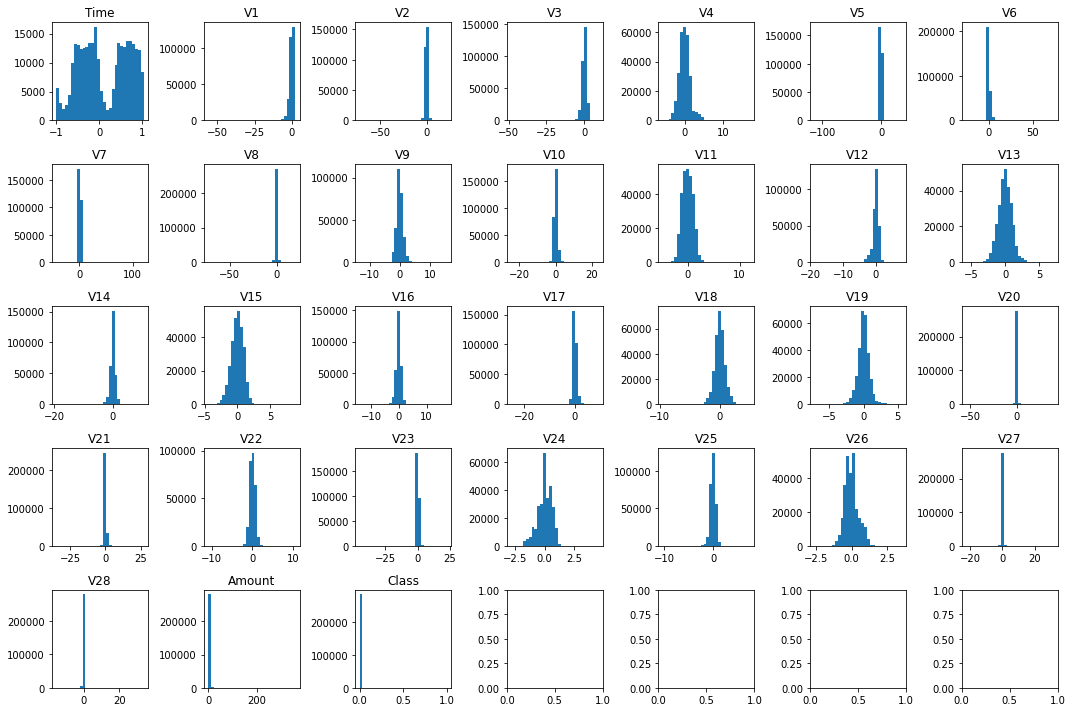

In [4]:
## Check distribution of features ## 
nrows = 5
ncols = math.ceil(len(df.columns) / nrows)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))
axes = axes.flatten()

cols = df.columns
for i in range(len(cols)):
    axes[i].hist(df[cols[i]], bins=30)
    axes[i].set_title(cols[i])

plt.tight_layout()
plt.show()

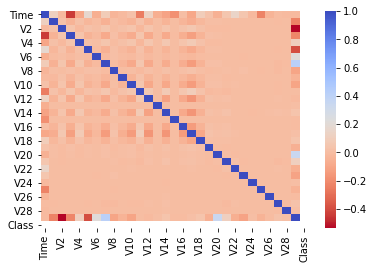

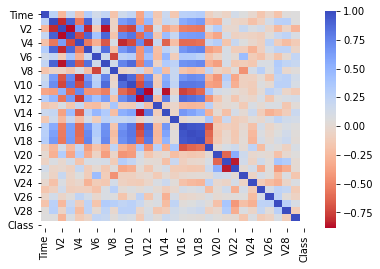

In [5]:
## The data above looks decent , all centralised 0 , already scaled ## 

## Now we look at the corrleation matrix for fraud and non-fraud ## 
non_fraud_df = df[df['Class'] == 0]
sns.heatmap(non_fraud_df.corr(), cmap='coolwarm_r', annot_kws={"size":20})
plt.show()

fraud_df = df[df['Class'] == 1]
sns.heatmap(fraud_df.corr(), cmap='coolwarm_r', annot_kws={"size":20})
plt.show()

In [6]:
## It appears that for fraud transactions, certain features are highly correlated , whereas in non-fraud, they are not ##

## To speed up training, we will use PCA to compress the dataset and retain 95% variance ## 
compressor = PCA()
compressor.fit(df.iloc[:, :-1]) # Exclude our target column
exp_var = compressor.explained_variance_ratio_

## Slice explained variance array until 95% is explained ## 
cut_off_num = len(exp_var[exp_var.cumsum() <= 0.96])

compressor = PCA(n_components=cut_off_num)
pc_df = compressor.fit_transform(df.iloc[:, :-1]) # Exclude our target column
pc_df = pd.DataFrame(pc_df)

## Add back the target column ##
pc_df = pd.concat([pc_df, df.iloc[:, -1]], axis=1)
pc_df.drop_duplicates(inplace=True)
pc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,Class
0,0.944740,1.379161,-1.832948,2.212350,1.067481,-0.302610,0.038880,-0.152115,0.392562,0.028951,...,0.141075,1.545972,-0.181294,0.453856,-0.155897,-0.082940,-0.446263,0.063052,0.281161,0
1,-1.367745,-0.962232,-0.101754,0.486106,0.454457,0.072662,0.077009,-0.079627,-0.328135,0.139175,...,0.099343,0.683891,0.021304,-0.462590,0.063999,0.232950,0.151244,0.273301,-0.701065,0
2,4.502193,0.791201,-1.748772,1.648949,0.039610,-1.379320,0.388871,-0.445409,-1.214947,-0.834878,...,0.068966,2.365391,-0.386010,2.847890,-0.974808,0.021386,2.126281,-0.126428,1.021258,0
3,0.592194,0.976287,-1.441142,1.219526,-1.009596,-1.200573,0.234362,-0.414331,-1.281472,-0.495008,...,0.301518,-0.572503,-0.277078,1.041254,0.867593,-1.675805,1.362371,0.200615,-0.212776,0
4,-0.292395,1.392390,-0.578043,1.786169,0.138355,-0.084818,-0.416271,0.138962,1.091949,-0.450974,...,0.973630,0.374163,-0.344644,0.447349,0.186964,0.120770,-0.856950,0.110209,0.686641,0


In [7]:
## Now we deal with the imbalance in classes via under-sampling ##
## We will under-sample the minority class ##
## Ideally we should over-sample, to retains the majority class data characteristics & increases training data for the QNN ##
## But I'm running a weak macbook.. so let's undersample to speed up things ## 

oversample = RandomUnderSampler(sampling_strategy='majority')
print(pc_df.shape)
X_over, y_over = oversample.fit_resample(pc_df.iloc[:,:-1], pc_df['Class'])
print(X_over.shape, y_over.shape)

(283726, 23)
(946, 22) (946,)


In [8]:
## Let's test it out on a classical ML Model to see the benchmark performance ##
## Train test split first ##
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.25)
classical_clf = RandomForestClassifier()
classical_clf.fit(X_train, y_train)

classical_y_pred = classical_clf.predict(X_test)
print("Classical Model Accuracy")
accuracy_score(y_test, classical_y_pred)

Classical Model Accuracy


0.9367088607594937

In [9]:
## Quantum ML Layer ##

## One hot encode the target variable ##
y_hot = tf.keras.utils.to_categorical(y_over, num_classes=2)

## Shuffle the data ##
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_over, y_hot = unison_shuffled_copies(X_over.values, y_hot)
## Creating the quantum node ##
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))

    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 2
weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

In [10]:
## Creating the Hybrid Model ## 
clayer_1 = tf.keras.layers.Dense(128)
clayer_2 = tf.keras.layers.Dense(256)
clayer_3 = tf.keras.layers.Dense(2)
clayer_5 = tf.keras.layers.Dense(2, activation='sigmoid')

model = tf.keras.Sequential([clayer_1, clayer_2, clayer_3, qlayer, clayer_5])
opt = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.BinaryCrossentropy()
model.compile(opt, loss=loss_function, metrics=["accuracy"])

In [11]:
history = model.fit(X_over, y_hot, epochs=6, batch_size=8, validation_split=0.25, verbose=1)

Epoch 1/6
89/89 [==============================] - 32s 356ms/step - loss: 0.6302 - accuracy: 0.6664 - val_loss: 0.6078 - val_accuracy: 0.7004
Epoch 2/6
89/89 [==============================] - 33s 374ms/step - loss: 0.5759 - accuracy: 0.7042 - val_loss: 0.6375 - val_accuracy: 0.6498
Epoch 3/6
89/89 [==============================] - 27s 299ms/step - loss: 0.6308 - accuracy: 0.6558 - val_loss: 0.6177 - val_accuracy: 0.6793
Epoch 4/6
89/89 [==============================] - 25s 282ms/step - loss: 0.6386 - accuracy: 0.6586 - val_loss: 0.5902 - val_accuracy: 0.6878
Epoch 5/6
89/89 [==============================] - 26s 296ms/step - loss: 0.5829 - accuracy: 0.7144 - val_loss: 0.5953 - val_accuracy: 0.7089
Epoch 6/6
89/89 [==============================] - 25s 284ms/step - loss: 0.5717 - accuracy: 0.7630 - val_loss: 0.5633 - val_accuracy: 0.7384


In [12]:
## Using a classical NN ##
clayer_1 = tf.keras.layers.Dense(128)
clayer_2 = tf.keras.layers.Dense(256)
clayer_3 = tf.keras.layers.Dense(256)
clayer_4 = tf.keras.layers.Dense(128)
clayer_5 = tf.keras.layers.Dense(2, activation='sigmoid')

c_model = tf.keras.Sequential([clayer_1, clayer_2, clayer_3, clayer_4, clayer_5])
opt = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.BinaryCrossentropy()
c_model.compile(opt, loss=loss_function, metrics=["accuracy"])

history = c_model.fit(X_over, y_hot, epochs=6, batch_size=32, validation_split=0.25, verbose=1)

Epoch 1/6
23/23 [==============================] - 1s 13ms/step - loss: 0.5288 - accuracy: 0.7932 - val_loss: 0.2553 - val_accuracy: 0.9156
Epoch 2/6
23/23 [==============================] - 0s 6ms/step - loss: 0.3326 - accuracy: 0.9093 - val_loss: 0.1880 - val_accuracy: 0.9325
Epoch 3/6
23/23 [==============================] - 0s 4ms/step - loss: 0.2240 - accuracy: 0.9279 - val_loss: 0.2064 - val_accuracy: 0.9367
Epoch 4/6
23/23 [==============================] - 0s 4ms/step - loss: 0.2015 - accuracy: 0.9300 - val_loss: 0.1932 - val_accuracy: 0.9325
Epoch 5/6
23/23 [==============================] - 0s 4ms/step - loss: 0.1563 - accuracy: 0.9393 - val_loss: 0.1326 - val_accuracy: 0.9367
Epoch 6/6
23/23 [==============================] - 0s 4ms/step - loss: 0.1612 - accuracy: 0.9385 - val_loss: 0.1432 - val_accuracy: 0.9325


In [13]:
## Get model predictions from QNN ##
q_nn_pred = model.predict(X_test)
q_nn_pred = np.where(q_nn_pred[:, 0] > q_nn_pred[:, 1], 0, 1)

## Get model predictions from NN ##
c_nn_pred = c_model.predict(X_test)
c_nn_pred = np.where(c_nn_pred[:, 0] > c_nn_pred[:, 1], 0, 1)

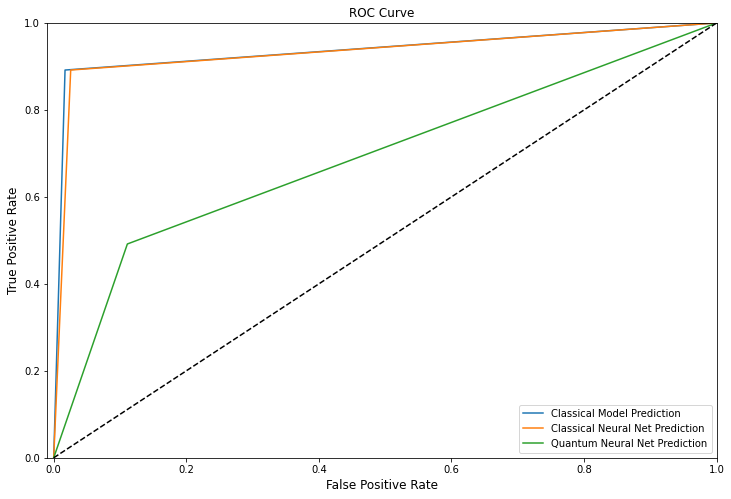

In [14]:
## Plot AUC ROC curve to measure performance ##
plt.figure(figsize=(12,8))

c_fpr , c_tpr, _ = roc_curve(y_test, classical_y_pred)
q_fpr, q_tpr, _ = roc_curve(y_test, q_nn_pred)
cnn_fpr, cnn_tpr, _ = roc_curve(y_test, c_nn_pred)

plt.plot(c_fpr, c_tpr, label="Classical Model Prediction")
plt.plot(cnn_fpr, cnn_tpr, label="Classical Neural Net Prediction")
plt.plot(q_fpr, q_tpr, label="Quantum Neural Net Prediction")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.title("ROC Curve", fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc=0)
plt.show()

### Closing Thoughts

1. QNN needs more data to tune all the params
2. Results might be very different with larger data set
3. We have 22 features (principal components), but only 2 qubits to model the data. Therefore high % of information loss.
4. This corresponds with the fact that for simple problems -> classical machine learning usually suffice